In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first
#!pip install --user seawater==3.3.4
#import seawater

# PWD IS  /g/data/xv83/np1383/src_CAFE60_eqpac_analysis_codesrc_CAFE60_eqpac_analysis/16-transport_test.ipynb
import time
os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [2]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")#47GB")
    #cluster = SLURMCluster(cores=8,processes=4,memory="22GB")#47GB")
    
    client = Client(cluster)
    cluster.scale(cores=32)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

In [3]:
cluster

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.161:46137,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load preprocessed Data

In [5]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [6]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40),lon_x=slice(120,290),lat_x=slice(-40,40))

phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
# I cut out ensemble 25 previously, path is '/g/data4/xv83/np1383/processed_data/physics_ds/ .... tx_trans_physics_feb7.nc

# Load Data
dic=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_pac_feb7.nc') #physics_ds
cafe_x_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans.chunk('auto')
cafe_y_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans.chunk('auto')
cafe_x_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm.chunk('auto') # Including eddies or subscale processes?
cafe_y_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm.chunk('auto')
# y is v and x is u directions?

adic_cafe=dic['adic'].chunk('auto')
dic_cafe=dic['dic'].chunk('auto')
anth_dic_cafe=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__.chunk('auto')

adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt


cafe_co2=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
cafe_co2_natural=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
cafe_co2_anth=cafe_co2-cafe_co2_natural


cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
#cafe_co2_anth


area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})


# Since we are calculating the below in mmol/m3/s, compared to the cafe transport calcs from CAFE which are in sverdrups 1,000,000 m3/s

upwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups



upwelling_cafe_100=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-100,method='nearest') #
upwelling_cafe_300=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-300,method='nearest') #
upwelling_cafe_500=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-500,method='nearest') #
upwelling_cafe_700=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-700,method='nearest') #
upwelling_cafe_900=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-900,method='nearest') #

upwelling_100=(upwelling_cafe_100.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-100,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_100=(upwelling_cafe_100.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-100,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_300=(upwelling_cafe_300.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-300,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_300=(upwelling_cafe_300.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-300,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_500=(upwelling_cafe_500.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-500,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_500=(upwelling_cafe_500.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-500,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_700=(upwelling_cafe_700.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-700,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_700=(upwelling_cafe_700.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-700,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_900=(upwelling_cafe_900.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-900,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_900=(upwelling_cafe_900.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-900,method='nearest')*area_m2)#/1e6 # To Sverdrups



anthflux=((cafe_co2_anth*-1)*area_m2)#/1e6 # Or maybe 9? # To Sverdrups (Because skin not m3? I have no idea).
flux=((cafe_co2*-1)*area_m2)#/1e6 #Or mabe 9? To Sverdrups


# EVERYTHING SHOULD BE IN MMOL/S


In [8]:
cafe_x_tx

<xarray.DataArray 'tx_trans' (time: 731, st_ocean: 30, lat: 140, lon_x: 171)>
dask.array<xarray-<this-array>, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.00000002e+20  1.00000002e+20]

In [9]:
# mmol/s
#10^9 kg/s

In [10]:
# Compare Area vs Transport??

In [11]:
#area_m2/1e6

### Check some of the vars to make sure they look ok

In [12]:
cafe_x_tx

#mmol/m3 * 1e9 KG/S (/1e6?)

<xarray.DataArray 'tx_trans' (time: 731, st_ocean: 30, lat: 140, lon_x: 171)>
dask.array<xarray-<this-array>, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.00000002e+20  1.00000002e+20]

In [13]:
adic_cafe

<xarray.DataArray 'adic' (time: 731, st_ocean: 30, lat: 140, lon: 170)>
[521934000 values with dtype=float32]
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     adic
    units:         mmol/m^3
    valid_range:   [-1000000.  1000000.]

In [14]:
dic_cafe

<xarray.DataArray 'dic' (time: 731, st_ocean: 30, lat: 140, lon: 170)>
[521934000 values with dtype=float32]
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     dic
    units:         mmol/m^3
    valid_range:   [-1000000.  1000000.]

In [15]:
cafe_co2_anth

<xarray.DataArray (time: 720, lat: 140, lon: 170)>
array([[[-8.12692815e-05, -8.05905293e-05, -8.20420464e-05, ...,
                     nan,             nan,             nan],
        [-6.27744885e-05, -6.36629266e-05, -6.60276419e-05, ...,
                     nan,             nan,             nan],
        [-4.99513044e-05, -5.13415143e-05, -5.46429619e-05, ...,
                     nan,             nan,             nan],
        ...,
        [            nan, -2.59818335e-05, -3.11375188e-05, ...,
         -1.01243699e-04, -1.02947000e-04, -1.06701322e-04],
        [-1.92235748e-05, -3.19972460e-05, -3.46961024e-05, ...,
         -9.25098793e-05, -9.91586639e-05, -1.05985877e-04],
        [-2.11526640e-05, -3.40708648e-05, -3.36802186e-05, ...,
         -7.62597265e-05, -9.34339914e-05, -1.00215228e-04]],

       [[-4.17797819e-05, -3.93452137e-05, -3.69605914e-05, ...,
                     nan,             nan,             nan],
        [-4.07274892e-05, -3.91482645e-05, -3.71795686e-05, ...,
                     nan,             nan,             nan],
        [-4.05038336e-05, -3.78398254e-05, -3.61938655e-05, ...,
                     nan,             nan,             nan],
...
          4.58130380e-05,  3.81436475e-05,  3.83082443e-05],
        [ 6.15766112e-06,  1.95439279e-05,  2.09899772e-05, ...,
          7.02108446e-05,  6.37502671e-05,  5.76455386e-05],
        [ 1.10565015e-05,  2.25717340e-05,  2.25512740e-05, ...,
          6.59838988e-05,  6.79772347e-05,  7.34023342e-05]],

       [[-2.02712654e-05, -2.05903052e-05, -2.09384380e-05, ...,
                     nan,             nan,             nan],
        [-2.01107614e-05, -2.07197882e-05, -2.07053963e-05, ...,
                     nan,             nan,             nan],
        [-1.64308076e-05, -1.72205873e-05, -1.79971030e-05, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,  3.39869730e-05,  3.90992282e-05, ...,
          8.11240679e-05,  6.95347044e-05,  6.75038245e-05],
        [ 1.60184063e-05,  3.96328105e-05,  4.29397187e-05, ...,
          1.07914566e-04,  9.74847426e-05,  9.13539479e-05],
        [ 1.96226829e-05,  4.13808593e-05,  4.16727489e-05, ...,
          1.01620652e-04,  1.07105065e-04,  1.12273679e-04]]],
      dtype=float32)
Coordinates:
    ensemble  int32 25
    st_ocean  float64 5.0
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

## Key Tracer Calculation and Save. 

In [16]:
# Run tracer transport Calculation
# This will do the two sides of the box but not vertical (bottom / top)> Make new calc to get wt transport?
calculate_horizontal_tracers=False
if calculate_horizontal_tracers==True:
    names=['anth_dic_cafe','dic_cafe']
    for i,tracer in enumerate([anth_dic_cafe,dic_cafe]):
        tracer_u=tracer.rename({'lon':'lon_x'}).chunk('auto')
        tracer_v=tracer.rename({'lat':'lat_x'}).chunk('auto')

        tracer_u_interp=tracer_u.interp(lon_x=cafe_x_tx.lon_x) # U is X (lon)
        tracer_v_interp=tracer_v.interp(lat_x=cafe_y_tx.lat_x) # V is Y (lat)

        # Do need to take mean of adjacent pixels still or not?
        adjacent_boxes=False
        if adjacent_boxes==True:
            tracer_u_tx=tracer_u_interp.rolling(lat=2).mean()*cafe_x_tx.rolling(lon_x=2).mean()
            tracer_v_tx=tracer_v_interp.rolling(lon=2).mean()*cafe_y_tx.rolling(lat_x=2).mean()
        elif adjacent_boxes==False:
            tracer_u_tx=tracer_u_interp*cafe_x_tx
            tracer_v_tx=tracer_v_interp*cafe_y_tx

        # Rename back to main grid so we can use the coords easily
        tracer_u_tx=tracer_u_tx.rename({'lon_x':'lon'})
        tracer_v_tx=tracer_v_tx.rename({'lat_x':'lat'})
        print('saving')
        tracer_u_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_u_transport.nc')
        print('u saved')
        tracer_v_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_v_transport.nc')
        print('v saved')
        
anth_dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
anth_dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
# Units of these should be mmolC/m3 to then SV(kg/s) = mmolC /s so MMol/s *10e6

# Test they look OK
test=False
if test==True:
    #chunk({'time':-1}).sel(time=slice('2000-01-01','2020-01-01')).
    anth_dic_v_tx.mean(dim='time').sel(lat=-3,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
    plt.show()
    anth_dic_u_tx.mean(dim='time').sel(lon=180,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
    plt.show()
    anth_dic_u_tx.mean(dim='time').sel(lat=0,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')

In [17]:
client

<Client: 'tcp://10.0.128.161:46137' processes=8 threads=32, memory=175.12 GiB>

In [18]:
cafe_y_tx_gm=xr.open_dataset(f'../processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm.chunk('auto')
cafe_x_tx_gm=xr.open_dataset(f'../processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm.chunk('auto')

In [19]:
#cafe_y_tx_gm.sel(lat=3,lon_x=180,time='2000-01-01',method='nearest').tx_trans_gm.plot()

In [20]:
cafe_x_tx_gm#tracer.rename({'lon':'lon_x'})

<xarray.DataArray 'tx_trans_gm' (time: 731, st_ocean: 30, lat: 140, lon_x: 171)>
dask.array<xarray-<this-array>, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     T-cell mass i-transport from GM
    units:         Sv (10^9 kg/s)
    valid_range:   [-1.00000002e+20  1.00000002e+20]

In [21]:

calculate_horizontal_tracers_gm=False
if calculate_horizontal_tracers_gm==True:
    cafe_y_tx_gm=xr.open_dataset(f'../processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm.chunk('auto')
    cafe_x_tx_gm=xr.open_dataset(f'../processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm.chunk('auto')

    names=['dic_cafe','anth_dic_cafe']
    for i,tracer in enumerate([dic_cafe,anth_dic_cafe]):# anth_dic_cafe
        tracer_u=tracer.rename({'lon':'lon_x'}).chunk('auto')
        tracer_v=tracer.rename({'lat':'lat_x'}).chunk('auto')

        tracer_u_interp=tracer_u.interp(lon_x=cafe_x_tx_gm.lon_x) # U is X (lon)
        tracer_v_interp=tracer_v.interp(lat_x=cafe_y_tx_gm.lat_x) # V is Y (lat)

        # Do need to take mean of adjacent pixels still or not?
        adjacent_boxes=False
        if adjacent_boxes==True:
            tracer_u_tx=tracer_u_interp.rolling(lat=2).mean()*cafe_x_tx_gm.rolling(lon_x=2).mean()
            tracer_v_tx=tracer_v_interp.rolling(lon=2).mean()*cafe_y_tx_gm.rolling(lat_x=2).mean()
        elif adjacent_boxes==False:
            tracer_u_tx=tracer_u_interp*cafe_x_tx_gm
            tracer_v_tx=tracer_v_interp*cafe_y_tx_gm

        # Rename back to main grid so we can use the coords easily
        tracer_u_tx=tracer_u_tx.rename({'lon_x':'lon'})
        tracer_v_tx=tracer_v_tx.rename({'lat_x':'lat'})
        print('saving')
        tracer_u_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_u_transport_gm.nc')
        print('u saved')
        tracer_v_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_v_transport_gm.nc')
        print('v saved')
        
anth_dic_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
anth_dic_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
dic_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
dic_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
# Units of these should be mmolC/m3 to then SV(kg/s) = mmolC /s so MMol/s *10e6

## Calculate ENSO Months

In [22]:
#anth_dic_u_tx

In [23]:
#Calculate ENSO

#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time<np.datetime64('2020-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values
#grid_multiplier_lat
#grid_multiplier_lon

In [24]:
# Function to get total above and below a certain cutoff in the maps.

def xarray_posneg_calc(inputds,enso_months,cutoff=0,mean=False,printer=True,mmols_to_pgYr_convert=True,run_density_calc=True,lat=None,lon=None):
    ds=inputds.sel(time=enso_months).mean(dim='time')#.copy(deep=True)
    ds1=ds
    if mmols_to_pgYr_convert==True:   
        ds=(ds*60*60*24*12*365)/1e18 # From Seconds to Minute to Hour to Day to Year to Milligrams to Petagrams
           
        
    pos=ds.where(ds>cutoff)
    neg=ds.where(ds<-cutoff)
    if mean==True:
        res=[pos.mean().values,neg.mean().values]
    elif mean==False:
        res=[pos.sum().values,neg.sum().values]
    if printer==True:
        print(f'Postive and negative sums {np.array(res)}')
        print(f'Total Sum {ds.sum().values}')
        #print(f'Total Sum Surface {ds.sel(st_ocean=slice(0,-100)).sum().values}')
        
        print(ds1.where(ds1>0).mean().values)
        try:
            print(density_tx.T)
        except:
            pass #Name Error?
    
    # MASK
    if run_density_calc==True:

        # NEED TO GET THE LAT OR LON FOR THE DENS BOX...
        density_timefix=cafe_potential_density.sel(time=enso_months).mean(dim='time')
        if lat is not None:
            density_timefix=density_timefix.sel(lat=lat,method='nearest')
        if lon is not None:
            density_timefix=density_timefix.sel(lon=lon,method='nearest')
        surface=ds.where(density_timefix.chunk('auto')<1023)
        upperthermocline=ds.where((density_timefix.chunk('auto')>=1023)&(density_timefix.chunk('auto')<1024.5))
        lowerthermocline=ds.where((density_timefix.chunk('auto')>=1024.5)&(density_timefix.chunk('auto')<1026.3))
        thermostad=ds.where((density_timefix.chunk('auto')>=1026.3))
        #print(surface)
        #print(surface.sum())
        surface_sum=surface.sum().values
        upperthermocline_sum=upperthermocline.sum().values
        lowerthermocline_sum=lowerthermocline.sum().values
        thermostad_sum=thermostad.sum().values

        density_tx=pd.DataFrame({'surface_sum':surface_sum,
                      'upperthermocline_sum':upperthermocline_sum,
                      'lowerthermocline_sum':lowerthermocline_sum,
                      'thermostad_sum':thermostad_sum,
                      'Total Sum':ds.sum().values      ,    
                      'Total Sum 100m':ds.sel(st_ocean=slice(0,-100)).sum().values,
                      'Positive Sum':res[0],
                      'Negative Sum':res[1]}, index=[0])

        return density_tx#np.array(res)
    else:
        return res

In [25]:
#cafe_potential_density.sel(time=neutral_events).mean(dim='time').chunk('auto')

In [26]:
#anth_dic_v_tx.sel(st_ocean=slice(0,-100))

In [27]:
# Regrid at least the u and v componetns to the density grid.
anth_dic_v_tx_gm=anth_dic_v_tx_gm.interp(lat=cafe_potential_density.lat,method='nearest').chunk('auto')
dic_v_tx_gm=dic_v_tx_gm.interp(lat=cafe_potential_density.lat,method='nearest').chunk('auto')

anth_dic_u_tx_gm=anth_dic_u_tx_gm.interp(lon=cafe_potential_density.lon,method='nearest').chunk('auto')
dic_u_tx_gm=dic_u_tx_gm.interp(lon=cafe_potential_density.lon,method='nearest').chunk('auto')


In [28]:
dic_transport_through_box=pd.DataFrame()

In [29]:
#test
test=False
if test==True:
    enso_mont=nina_events
    cpd=cafe_potential_density.chunk('auto').sel(time=enso_mont).mean(dim='time')
    t_ex=(anth_dic_v_tx.chunk('auto').sel(time=enso_mont).mean(dim='time')*60*60*24*12*365)/1e18
    surface=t_ex.where((cpd.chunk('auto')<1023))
    upperthermocline=t_ex.where((cpd.chunk('auto')>=1023)&(cpd.chunk('auto')<1024.5))
    lowerthermocline=t_ex.where((cpd.chunk('auto')>=1024.5)&(cpd.chunk('auto')<1026.3))
    thermostad=t_ex.where((cpd.chunk('auto')>=1026.3))
    print(surface.sel(lat=-3,method='nearest').sum().values)
    print(upperthermocline.sel(lat=-3,method='nearest').sum().values)
    print(lowerthermocline.sel(lat=-3,method='nearest').sum().values)
    print(thermostad.sel(lat=-3,method='nearest').sum().values)

In [30]:
#upperthermocline.sel(lat=-3,method='nearest').plot()
#lowerthermocline.sel(lat=-3,method='nearest').plot()

# Start the Figures

### Plot 1 and 2: North and South Faces

In [31]:
#client#.restart()

In [40]:
cluster

In [32]:
#densitylevs=[1022,1024.5,1026.7]#6.9]
#(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)

Postive and negative sums [ 2.8245842e-07 -4.1245539e-08]
Total Sum 2.4121291630763153e-07
0.283907


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 2.260704e-07 -4.828966e-08]
Total Sum 1.7778074834495783e-07
0.23472969


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 3.0302922e-07 -5.7842101e-08]
Total Sum 2.4518715235899435e-07
0.29635435


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 3.2978801e-07 -2.5593993e-08]
Total Sum 3.041940033199353e-07
0.31179217


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 1.7157616e-07 -4.2379583e-08]
Total Sum 1.2919655034693278e-07
0.19383796


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 1.4313034e-07 -5.1087493e-08]
Total Sum 9.204283912822575e-08
0.1580524


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 1.8607973e-07 -3.9418506e-08]
Total Sum 1.4666120762285573e-07
0.1909563


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 1.8279816e-07 -3.0286881e-08]
Total Sum 1.5251129070747993e-07
0.20347135


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


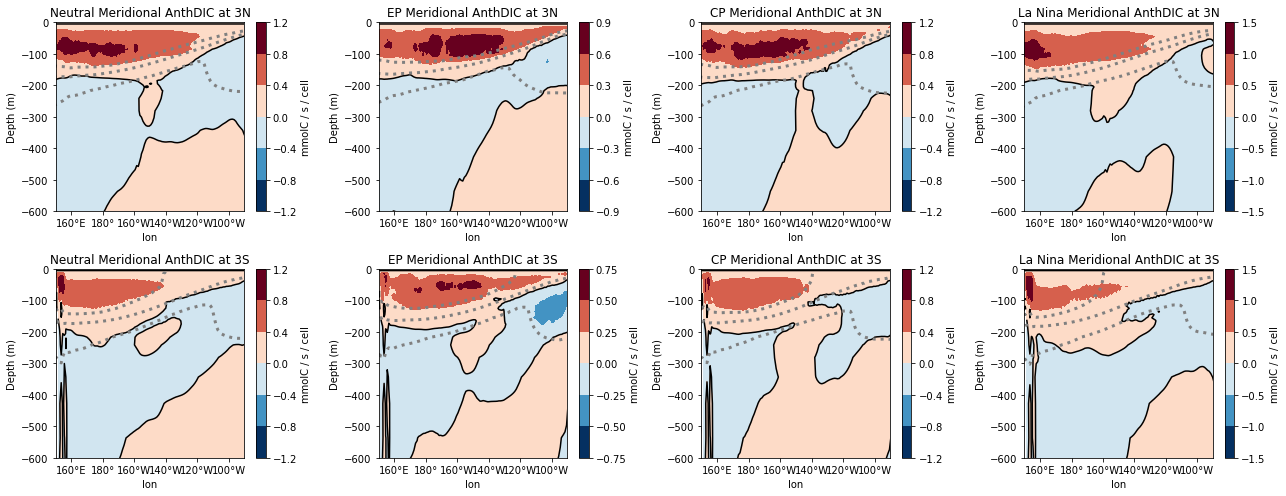

Postive and negative sums [ 1.0287168e-05 -2.7166502e-06]
Total Sum 7.57051884647808e-06
10.48348


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 8.122756e-06 -2.856415e-06]
Total Sum 5.266340849630069e-06
8.460482


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 1.0786803e-05 -3.6937085e-06]
Total Sum 7.093094609444961e-06
10.748093


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 1.20167215e-05 -1.79402718e-06]
Total Sum 1.0222695891570766e-05
11.640022


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 6.1116280e-06 -2.3952132e-06]
Total Sum 3.7164147670409875e-06
6.898706


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 5.027198e-06 -2.759335e-06]
Total Sum 2.2678634650219465e-06
5.555953


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 6.6109847e-06 -2.1072970e-06]
Total Sum 4.503688160184538e-06
6.72159


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 6.5742847e-06 -1.7546803e-06]
Total Sum 4.819604782824172e-06
7.2870946


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


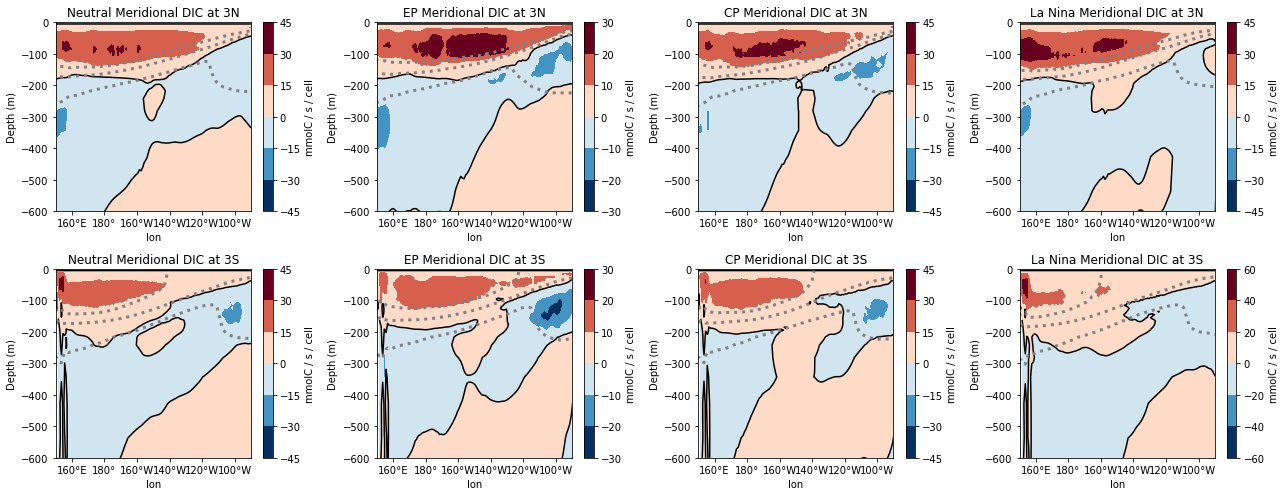

CPU times: user 3min 14s, sys: 38.8 s, total: 3min 53s
Wall time: 27min 15s


,surface_sum,upperthermocline_sum,lowerthermocline_sum,thermostad_sum,Total Sum,Total Sum 100m,Positive Sum,Negative Sum
Neutral Meridional AnthDIC at 3N,2.396146e-07,2.720620e-08,-9.705980e-09,-1.590196e-08,2.412129e-07,2.063709e-07,2.824584e-07,-4.124554e-08
EP Meridional AnthDIC at 3N,1.900747e-07,2.392921e-08,-2.468329e-08,-1.153994e-08,1.777807e-07,1.706663e-07,2.260704e-07,-4.828966e-08
CP Meridional AnthDIC at 3N,2.508228e-07,3.464537e-08,-2.108631e-08,-1.919477e-08,2.451872e-07,2.151681e-07,3.030292e-07,-5.784210e-08
Nina Meridional AnthDIC at 3N,2.768831e-07,3.194445e-08,4.067041e-09,-8.700610e-09,3.041940e-07,2.238849e-07,3.297880e-07,-2.559399e-08
Neutral Meridional AnthDIC at 3S,1.263556e-07,3.425656e-08,-2.345303e-08,-7.962524e-09,1.291966e-07,1.264717e-07,1.715762e-07,-4.237958e-08
EP Meridional AnthDIC at 3S,1.021233e-07,2.838829e-08,-3.441656e-08,-4.052170e-09,9.204284e-08,1.002183e-07,1.431303e-07,-5.108749e-08
CP Meridional AnthDIC at 3S,1.422312e-07,2.837882e-08,-2.481642e-08,8.676401e-10,1.466612e-07,1.330821e-07,1.860797e-07,-3.941851e-08
Nina Meridional AnthDIC at 3S,1.169121e-07,5.520993e-08,-1.380507e-08,-5.805658e-09,1.525113e-07,1.357464e-07,1.827982e-07,-3.028688e-08
Neutral Meridional AnthDIC at 3N,2.396146e-07,2.720620e-08,-9.705980e-09,-1.590196e-08,2.412129e-07,2.063709e-07,2.824584e-07,-4.124554e-08
EP Meridional AnthDIC at 3N,1.900747e-07,2.392921e-08,-2.468329e-08,-1.153994e-08,1.777807e-07,1.706663e-07,2.260704e-07,-4.828966e-08


In [41]:
%%time
longitude_labels=['','160°E','180°','160°W','140°W','120°W','100°W']
densitylevs=[1023,1024.5,1026.3]#,1026.7,1027,1027.5]
ylim=-600

plot=True
if plot==True:
    N_S_data_holder=[anth_dic_v_tx_gm.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)),
                     dic_v_tx_gm.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700))]
                     #((grid_multiplier_lon*(anth_dic_tx_v_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T)]

    N_S_names=['Meridional AnthDIC','Meridional DIC']#,'Old Attempt']


    for i, N_S_data in enumerate(N_S_data_holder):
        plt.figure(figsize=(18,7))

        for xi,lat in enumerate([3,-3]):
            #Client.restart()
            #time.sleep(10)
            adic_tx_n=N_S_data.sel(lat=lat,method='nearest')#(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T
            if lat==3: 
                direct='3N'
                adic_tx_n=adic_tx_n*-1  # Calculate Transport OUT of the box
            if lat==-3: direct='3S'

            
            
            if ((i==0)|(i==2)): 
                levs=None#np.arange(-4e6,4.5e6,5e5)
            elif i==1: 
                levs=None#np.arange(-1e8,1.1e8,1e7)
            #else: levs=np.arange(-10,10,1)
            contour=[0]#60,-60]
            
         

            subpl=plt.subplot(2,4,1+(xi*4))        
            ax=adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_neutral=xarray_posneg_calc(adic_tx_n,enso_months=neutral_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_neutral.index=[f'Neutral {N_S_names[i]} at {direct}']
            #print(asum)
            plt.title(f'Neutral {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            plt.ylim([ylim,0])
            subpl.set_xticklabels(longitude_labels)
            plt.ylabel('Depth (m)')
            
            #cbar=plt.colorbar(ax)
            #cbar.set_label()#, rotation=270)

            subpl=plt.subplot(2,4,2+(xi*4))
            adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_ep=xarray_posneg_calc(adic_tx_n,enso_months=ep_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_ep.index=[f'EP {N_S_names[i]} at {direct}']
            #print(asum)
            plt.title(f'EP {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            subpl.set_xticklabels(longitude_labels)

            subpl=plt.subplot(2,4,3+(xi*4))
            adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_cp=xarray_posneg_calc(adic_tx_n,enso_months=cp_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_cp.index=[f'CP {N_S_names[i]} at {direct}']
            plt.title(f'CP {N_S_names[i]} at {direct}')
            subpl.set_xticklabels(longitude_labels)
            plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            
            subpl=plt.subplot(2,4,4+(xi*4))
            adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_nina=xarray_posneg_calc(adic_tx_n,enso_months=nina_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_nina.index=[f'Nina {N_S_names[i]} at {direct}']
            plt.title(f'La Nina {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            subpl.set_xticklabels(longitude_labels)
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            
            temp_holder=pd.concat([asum_neutral,asum_ep,asum_cp,asum_nina])#,index=[f'{N_S_names[i]} in {direct}',f'{N_S_names[i]} out {direct}'])
            dic_transport_through_box=dic_transport_through_box.append(temp_holder)
        plt.tight_layout()
        plt.show()
        
dic_transport_through_box                                     

In [34]:
asum_neutral#.index=['hi']

,surface_sum,upperthermocline_sum,lowerthermocline_sum,thermostad_sum,Total Sum,Total Sum 100m,Positive Sum,Negative Sum
Neutral Meridional AnthDIC at 3S,1.263556e-07,3.425656e-08,-2.345303e-08,-7.962524e-09,1.291966e-07,1.264717e-07,1.715762e-07,-4.237958e-08


In [43]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")#47GB")
    #cluster = SLURMCluster(cores=8,processes=4,memory="22GB")#47GB")
    
    client = Client(cluster)
    cluster.scale(cores=32)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36757 instead
  warnings.warn(


In [36]:
time.sleep(20)

In [47]:
cluster

In [38]:
anth_dic_u_tx

<xarray.DataArray '__xarray_dataarray_variable__' (time: 731, st_ocean: 30, lat: 140, lon: 171)>
dask.array<mul, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
  * lon       (lon) float64 120.0 121.0 122.0 123.0 ... 287.0 288.0 289.0 290.0

### Plot 3+4: Western and Eastern Faces

Postive and negative sums [ 6.0493126e-09 -7.6772278e-12]
Total Sum 6.041635636222509e-09
0.03633001


<timed exec>:52: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 1.2936122e-09 -8.8081861e-11]
Total Sum 1.2055304532410105e-09
0.008503353


<timed exec>:69: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 3.0845053e-09 -1.1451870e-10]
Total Sum 2.9699864789733965e-09
0.019499406


<timed exec>:82: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 1.0194004e-08 -5.9558643e-12]
Total Sum 1.018804685060104e-08
0.05999438


<timed exec>:95: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 9.0108154e-10 -6.1388711e-10]
Total Sum 2.871944626559042e-10
0.0086271465


<timed exec>:52: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 1.1278207e-09 -9.6505270e-10]
Total Sum 1.627680212834548e-10
0.010797995


<timed exec>:69: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 1.0737624e-09 -4.6219528e-10]
Total Sum 6.115671302708847e-10
0.009489627


<timed exec>:82: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 7.8417106e-10 -4.7950049e-10]
Total Sum 3.0467056655325564e-10
0.005853555


<timed exec>:95: UserWarning: FixedFormatter should only be used together with FixedLocator


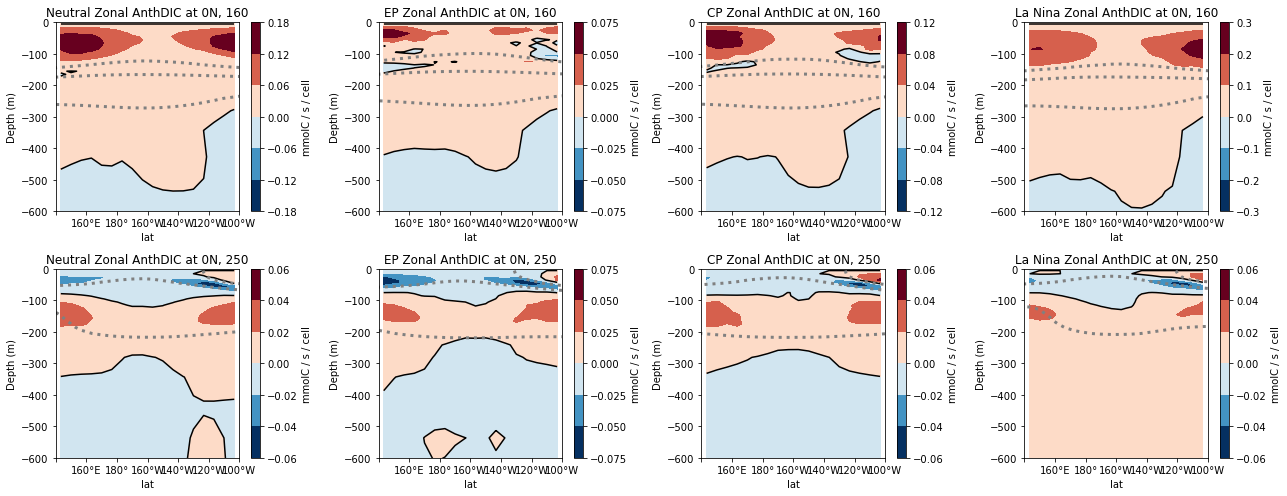

Postive and negative sums [ 2.0311958e-07 -9.1465768e-10]
Total Sum 2.0220491592226608e-07
1.2198637


<timed exec>:52: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 4.3065292e-08 -4.5743520e-09]
Total Sum 3.8490934883839145e-08
0.2873719


<timed exec>:69: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 1.0880286e-07 -4.6432160e-09]
Total Sum 1.0415963913601445e-07
0.6878221


<timed exec>:82: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 3.5106686e-07 -7.3578543e-10]
Total Sum 3.5033107792514784e-07
2.0615292


<timed exec>:95: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 5.5009931e-08 -2.5990786e-08]
Total Sum 2.9019140868058457e-08
0.53442204


KilledWorker: ("('xarray-<this-array>-77f15d1959633efc683daacd60019eb4', 4, 0, 1, 0)", <WorkerState 'tcp://10.0.128.13:45465', name: SLURMCluster-2-1, memory: 0, processing: 18>)

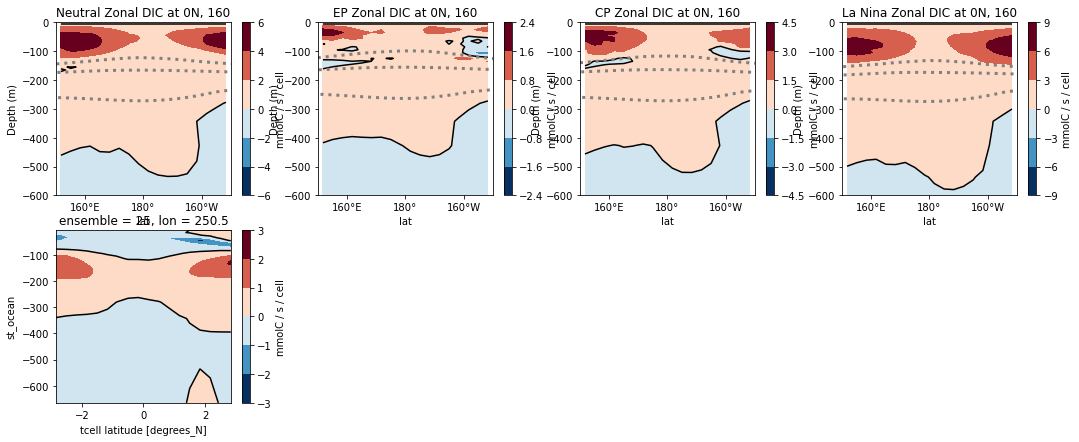

In [48]:
%%time

plot=True
if plot==True:

    #anth DIC
    E_W_data_holder=[anth_dic_u_tx_gm.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)),
                     dic_u_tx_gm.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700))]
                     #((grid_multiplier_lat*(anth_dic_tx_u_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T*-1)] # Wrong Direction

    E_W_names=['Zonal AnthDIC','Zonal DIC']#,'Zonal Old Attempt']


    for i, E_W_data in enumerate(E_W_data_holder):
        #Client.restart()
        #time.sleep(10)
        ylim=-600
        plt.figure(figsize=(18,7))
        lons=[160,250]
        for xi, lon in enumerate(lons):
            if i==0 or i==2:
                levs=None#np.arange(-2e7,2.1e7,1e6)#None#np.arange(-20,22,2)
            elif i==1:# or i==3:
                levs=None#np.arange(-1e9,1.05e9,5e7)#None#np.arange(-1000,1100,100)
                
                
            #elif i<=4:  
            #levs=None#np.arange(-1e7,1e7,1e6)
            contour=[0]#60,-60]
            
            #lon=180
            lslice=slice(-3,3)

            
            #plt.subplot(251)
            subpl=plt.subplot(2,4,1+(xi*4))

            adic_tx_b=E_W_data.sel(lon=lon,method='nearest').sel(lat=lslice)#.T#grid_multiplier_lat.T*anth_dic_tx_u.sel(lon=lon,method='nearest')#.mean(dim='time')
            if lon==250:
                adic_tx_b*=-1 # Calculate Transport OUT of box. 

            #print(adic_tx_b)
            #(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T

            adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_neutral=xarray_posneg_calc(adic_tx_b,enso_months=neutral_events,lon=lon)
            asum_neutral.index=[f'Neutral {E_W_names[i]} at {lon}']
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'Neutral {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            subpl.set_xticklabels(longitude_labels)
            
            plt.ylabel('Depth (m)')
            plt.xlim([-3,3])

            subpl=plt.subplot(2,4,2+(xi*4))
            adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_ep=xarray_posneg_calc(adic_tx_b,enso_months=ep_events,lon=lon)
            asum_ep.index=[f'EP {E_W_names[i]} at {lon}']
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'EP {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            plt.xlim([-3,3])
            subpl.set_xticklabels(longitude_labels)
               
            subpl=plt.subplot(2,4,3+(xi*4))
            adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_cp=xarray_posneg_calc(adic_tx_b,enso_months=cp_events,lon=lon)
            asum_cp.index=[f'CP {E_W_names[i]} at {lon}']
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            plt.title(f'CP {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.xlim([-3,3])
            plt.ylabel('Depth (m)')
            subpl.set_xticklabels(longitude_labels)

            subpl=plt.subplot(2,4,4+(xi*4))
            adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_nina=xarray_posneg_calc(adic_tx_b,enso_months=nina_events,lon=lon)
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            plt.title(f'La Nina {E_W_names[i]} at 0N, {lon}')
            asum_nina.index=[f'Nina {E_W_names[i]} at {lon}']
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.xlim([-3,3])
            plt.ylabel('Depth (m)')
            subpl.set_xticklabels(longitude_labels)

            # Mmol DIC/m2/s
            #cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
            
            temp_holder=pd.concat([asum_neutral,asum_ep,asum_cp,asum_nina])#,index=[f'{N_S_names[i]} in {direct}',f'{N_S_names[i]} out {direct}'])
            dic_transport_through_box=dic_transport_through_box.append(temp_holder)
            
        plt.tight_layout()
        plt.show()
            #temp_holder

In [ ]:
dic_transport_through_box

In [ ]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")#47GB")
    #cluster = SLURMCluster(cores=8,processes=4,memory="22GB")#47GB")
    
    client = Client(cluster)
    cluster.scale(cores=32)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

In [ ]:
time.sleep(20)


### Plot 5+6: Upwelling and Outgassing (Vertical Top and Bottom Faces)
upwelling
anthupwelling

flux
anthflux


In [ ]:
cluster

In [ ]:
import sys
sys.exit()

In [ ]:
%%time
save_new_upwelling_density=False
if save_new_upwelling_density==True:
    upwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups (From m3?)
    anthupwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups


    upwelling=upwelling.interp(st_ocean=cafe_potential_density.st_ocean)
    anthupwelling=anthupwelling.interp(st_ocean=cafe_potential_density.st_ocean)


    surface_to_upperthermocline=upwelling.where((density_timefix.chunk('auto')>=1022.7)&(density_timefix.chunk('auto')<=1023.3)).mean(dim='st_ocean') #Average across a few pixels
    upper_to_lowerthermocline=upwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    lowerthermocline_to_thermostad=upwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    anth_surface_to_upperthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1022.7)&(density_timefix.chunk('auto')<=1023.3)).mean(dim='st_ocean') #Average across a few pixels
    anth_upper_to_lowerthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    anth_lowerthermocline_to_thermostad=anthupwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    print('saving')
    surface_to_upperthermocline.to_netcdf('../processed_data/upwelling_through_layers/surface_to_upperthermocline.nc')
    print('saving')
    upper_to_lowerthermocline.to_netcdf('../processed_data/upwelling_through_layers/upper_to_lowerthermocline.nc')
    print('saving')
    lowerthermocline_to_thermostad.to_netcdf('../processed_data/upwelling_through_layers/lowerthermocline_to_thermostad.nc')
    print('saving')
    anth_surface_to_upperthermocline.to_netcdf('../processed_data/upwelling_through_layers/anth_surface_to_upperthermocline.nc')
    print('saving')
    anth_upper_to_lowerthermocline.to_netcdf('../processed_data/upwelling_through_layers/anth_upper_to_lowerthermocline.nc')
    print('saving')
    anth_lowerthermocline_to_thermostad.to_netcdf('../processed_data/upwelling_through_layers/anth_lowerthermocline_to_thermostad.nc')

surface_to_upperthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/surface_to_upperthermocline.nc').__xarray_dataarray_variable__
upper_to_lowerthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/upper_to_lowerthermocline.nc').__xarray_dataarray_variable__
lowerthermocline_to_thermostad=xr.open_dataset('../processed_data/upwelling_through_layers/lowerthermocline_to_thermostad.nc').__xarray_dataarray_variable__

anth_surface_to_upperthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/anth_surface_to_upperthermocline.nc').__xarray_dataarray_variable__
anth_upper_to_lowerthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/anth_upper_to_lowerthermocline.nc').__xarray_dataarray_variable__
anth_lowerthermocline_to_thermostad=xr.open_dataset('../processed_data/upwelling_through_layers/anth_lowerthermocline_to_thermostad.nc').__xarray_dataarray_variable__


#Dens Calcs for upwelling
#dic_u_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_u_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__
#anth_dic_u_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_u_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__

#dic_v_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_v_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__
#anth_dic_v_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_v_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__
dic_w_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/upwelling_density.nc').tracer#.__xarray_dataarray_variable__
anth_dic_w_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anthupwelling_density.nc').tracer



#dic_w_tx_dens.sel(density=25,method='nearest').mean(dim='time').plot()


In [ ]:
plot=True

if plot==True:
    density_timefix=cafe_potential_density#.sel(time=enso_months).mean(dim='time')
    #Density FIxed Upwelling??
    contour=[0]
    
    #surface_to_upperthermocline=upwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
    #upper_to_lowerthermocline=upwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    #lowerthermocline_to_thermostad=upwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    #anth_surface_to_upperthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
    #anth_upper_to_lowerthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    #anth_lowerthermocline_to_thermostad=anthupwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    
    #anth DIC
    T_B_data_holder=[upwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     
                     surface_to_upperthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     upper_to_lowerthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     lowerthermocline_to_thermostad.sel(time=slice('2000-01-01','2020-01-01')),
                     
                     anth_surface_to_upperthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     anth_upper_to_lowerthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     anth_lowerthermocline_to_thermostad.sel(time=slice('2000-01-01','2020-01-01')),
                     
                     flux.sel(time=slice('2000-01-01','2020-01-01'))*-1,
                     anthflux.sel(time=slice('2000-01-01','2020-01-01'))*-1]
                     
                     #dic_w_tx_dens.sel(density=1023,method='nearest'),
                     #anth_dic_w_tx_dens.sel(density=1023,method='nearest'),

                     #dic_w_tx_dens.sel(density=1024.5,method='nearest'),
                     #anth_dic_w_tx_dens.sel(density=1024.5,method='nearest'),

                     #dic_w_tx_dens.sel(density=1026.3, method='nearest'),
                     #anth_dic_w_tx_dens.sel(density=1026.3,method='nearest')]

    #T_B_names=['Upwelling','Anthropogenic Upwelling','Upwelling Old', 'Anth Upwelling Old', 'CO2 flux', 'anth CO2 flux', 'CO2 flux OLD',' anth CO2 flux OLD']
    T_B_names=['Upwelling 100','AnthUpwelling 100','Upwelling 500','AnthUpwelling 500',
               'surface_to_upperthermocline','upper_to_lowerthermocline','lowerthermocline_to_thermostad',
               'anth_surface_to_upperthermocline','anth_upper_to_lowerthermocline','anth_lowerthermocline_to_thermostad',
               'CO2 flux', 'anth CO2 flux']#,'Upwelling 23','Anthropogenic Upwelling 23','Upwelling 24.5','Anthropogenic Upwelling 24.5','Upwelling 26.3','Anthropogenic Upwelling 26.3']


    for i, T_B_data in enumerate(T_B_data_holder):
        if i==0:
            levs=None#np.arange(-40,45,5)
        elif i==1:
            levs=None#np.arange(-2,2.2,0.2)
        
        plt.figure(figsize=(20,4))
        plt.subplot(141)
        lslice=slice(-3,3)
        upwelling_dat=T_B_data.sel(lat=lslice,lon=slice(150,270))

        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_neutral=xarray_posneg_calc(upwelling_dat,enso_months=neutral_events,run_density_calc=False)

        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'Neutral {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(142)
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_ep=xarray_posneg_calc(upwelling_dat,enso_months=ep_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'EP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(143)
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_cp=xarray_posneg_calc(upwelling_dat,enso_months=cp_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'CP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(144)
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_nina=xarray_posneg_calc(upwelling_dat,enso_months=nina_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'Nina {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])


        plt.tight_layout()
        plt.show()
         
        name_str=''
        if pd.Series(T_B_names[i]).str.contains('_to_').iloc[0] ==True:
            if pd.Series(T_B_names[i]).str.contains('anth').iloc[0] ==True:
                name_str='Anth Upwelling'
            else:
                name_str='Upwelling'
        else:
            name_str=T_B_names[i]
            
        temp_holder=pd.DataFrame({f'Neutral {name_str}':asum_neutral,
                                  f'EP {name_str}':asum_ep,
                                  f'CP {name_str}':asum_cp,
                                  f'Nina {name_str}':asum_nina},index=[f'{T_B_names[i]} in',f'{T_B_names[i]} out']).T #Transpose because i did it backwards
        dic_transport_through_box=dic_transport_through_box.append(temp_holder)

In [ ]:
dic_transport_through_box#=dic_transport_through_box[:-8]

In [ ]:
dic_transport_through_box.to_csv('dic_tx.csv')

## End Box Estimate

In [ ]:

dic_transport_through_box = pd.read_csv('dic_tx.csv',index_col=0)

#dic_transport_through_box
# in PgC/yr???"

In [ ]:
# Bit of Data Wrangling

dic_transport_through_box = pd.read_csv('dic_tx.csv',index_col=0)

dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['Upwelling 100 in']+dic_transport_through_box['Upwelling 100 out'])
dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['AnthUpwelling 100 in']+dic_transport_through_box['AnthUpwelling 100 out'])

dic_transport_through_box['upperthermocline_sum']=dic_transport_through_box['upperthermocline_sum'].fillna(
    dic_transport_through_box['surface_to_upperthermocline in']+dic_transport_through_box['surface_to_upperthermocline out'])
dic_transport_through_box['upperthermocline_sum']=dic_transport_through_box['upperthermocline_sum'].fillna(
    dic_transport_through_box['anth_surface_to_upperthermocline in']+dic_transport_through_box['anth_surface_to_upperthermocline out'])


dic_transport_through_box['lowerthermocline_sum']=dic_transport_through_box['lowerthermocline_sum'].fillna(
    dic_transport_through_box['upper_to_lowerthermocline in']+dic_transport_through_box['upper_to_lowerthermocline out'])
dic_transport_through_box['lowerthermocline_sum']=dic_transport_through_box['lowerthermocline_sum'].fillna(
    dic_transport_through_box['anth_upper_to_lowerthermocline in']+dic_transport_through_box['anth_upper_to_lowerthermocline out'])

dic_transport_through_box['thermostad_sum']=dic_transport_through_box['thermostad_sum'].fillna(
    dic_transport_through_box['lowerthermocline_to_thermostad in']+dic_transport_through_box['lowerthermocline_to_thermostad out'])

dic_transport_through_box['thermostad_sum']=dic_transport_through_box['thermostad_sum'].fillna(
    dic_transport_through_box['anth_lowerthermocline_to_thermostad in']+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])

dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['CO2 flux in']+dic_transport_through_box['CO2 flux out'])
dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['anth CO2 flux in']+dic_transport_through_box['anth CO2 flux out'])

#Total Sum 	Total Sum 100m 	Positive Sum 	Negative Sum
dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['CO2 flux in']+dic_transport_through_box['CO2 flux out'])
dic_transport_through_box['Positive Sum']=dic_transport_through_box['Positive Sum'].fillna(
    dic_transport_through_box['CO2 flux in'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])
dic_transport_through_box['Negative Sum']=dic_transport_through_box['Negative Sum'].fillna(
    dic_transport_through_box['CO2 flux out'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])

dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['anth CO2 flux in']+dic_transport_through_box['anth CO2 flux out'])
dic_transport_through_box['Positive Sum']=dic_transport_through_box['Positive Sum'].fillna(
    dic_transport_through_box['anth CO2 flux in'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])
dic_transport_through_box['Negative Sum']=dic_transport_through_box['Negative Sum'].fillna(
    dic_transport_through_box['anth CO2 flux out'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])



#dic_transport_through_box=dic_transport_through_box.drop(['Anthropogenic Upwelling 23 in','Anthropogenic Upwelling 23 out','Anthropogenic Upwelling 24.5 in','Anthropogenic Upwelling 24.5 out','Anthropogenic Upwelling 26.3 in','Anthropogenic Upwelling 26.3 out'],axis=1)
#dic_transport_through_box=dic_transport_through_box.drop(['Upwelling 23 in','Upwelling 23 out','Upwelling 24.5 in','Upwelling 24.5 out','Upwelling 26.3 in','Upwelling 26.3 out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['Upwelling 100 in','Upwelling 100 out','AnthUpwelling 100 in','AnthUpwelling 100 out'],axis=1)#,'Upwelling 23 out','Upwelling 24.5 in','Upwelling 24.5 out','Upwelling 26.3 in','Upwelling 26.3 out'],axis=1)

dic_transport_through_box=dic_transport_through_box.drop(['Upwelling 500 in','Upwelling 500 out','AnthUpwelling 500 in','AnthUpwelling 500 out'],axis=1)#,'Upwelling 23 out','Upwelling 24.5 in','Upwelling 24.5 out','Upwelling 26.3 in','Upwelling 26.3 out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['surface_to_upperthermocline in','surface_to_upperthermocline out','anth_surface_to_upperthermocline in','anth_surface_to_upperthermocline out','upper_to_lowerthermocline in','upper_to_lowerthermocline out','anth_upper_to_lowerthermocline in','anth_upper_to_lowerthermocline out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['lowerthermocline_to_thermostad in','lowerthermocline_to_thermostad out','anth_lowerthermocline_to_thermostad in','anth_lowerthermocline_to_thermostad out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['CO2 flux in','CO2 flux out','anth CO2 flux in','anth CO2 flux out'],axis=1)
dic_transport_through_box=dic_transport_through_box.dropna(thresh=1)

dic_transport_through_box.to_csv('dic_tx2.csv')

t=pd.read_csv('dic_tx2.csv').replace(0,np.nan)
merged=t.groupby('Unnamed: 0').mean().sort_values('Unnamed: 0').round(3)#agg(np.mean())

merged['enso_phase']=merged.index.str.split(' ').str[0]
merged.index=merged.index.str.split(' ').str[1:].str.join(' ')#.groupby('surface_sum')

merged.to_csv('dic_tx3.csv')
merged

In [ ]:
dic_transport_through_box=pd.read_csv(f'dic_tx3.csv',index_col=0).replace(0,np.nan)
# Should have been saved in Petagrams.
#dic_tx_pgC=((dic_transport_through_box)*12*60*60*24*365)/1e9 #
#dic_transport_through_box.iloc[-4:]=dic_transport_through_box.iloc[-4:]*-1

# Co2 Flux Directions are wrong way around.???

# Units are 1e9 mmoles/s
# Pretty sure this is Petagrams. is 15 and 50PG seem correct for meridional and zonal transport of C / yr? Outgassing is like 1, so probably?
# 12 (molC to gC) * seconds *minutes* hours*days / 1e9 (rather than 1e15 since we are in 1,000,000 kg/yr not g. 
#Rather than 1e15 # Because its already in 1,000,000kg/s ??

#dic_transport_through_box=dic_transport_through_box[~dic_transport_through_box.index.str.contains('100')]
#dic_transport_through_box=dic_transport_through_box[~dic_transport_through_box.index.str.contains('500')]



names=dic_transport_through_box.index

new_tx=dic_transport_through_box[~names.str.lower().str.contains('old')]
new_tx_anth=new_tx[new_tx.index.str.lower().str.contains('anth')]
for anth in new_tx_anth.index:
    if anth in new_tx.index:
        new_tx=new_tx.drop(anth)

In [ ]:
new_tx

In [ ]:
for col in new_tx.columns[:-1]:
    df=new_tx[[col,'enso_phase']]#.plot.bar()
    df.pivot(columns='enso_phase').plot.bar()#plt.show()

In [ ]:
for col in new_tx_anth.columns[:-1]:
    df=new_tx_anth[[col,'enso_phase']]#.plot.bar()
    df.pivot(columns='enso_phase').plot.bar()#plt.show()
    plt.title(col)

In [ ]:
new_tx_anth.index.str.split(' ').str[0]#.groupby('surface_sum')

In [ ]:
new_tx.index.str.split(' ').str[2]#.groupby('surface_sum')

In [ ]:
new_tx.index.str.split(' ').str[3]#.groupby('surface_sum')


In [ ]:
df=new_tx[[col,'enso_phase']]#set_index(['Unnamed: 0'])#.stack()

In [ ]:
#.groupby('enso_phase')[col].apply(list)
#df#.apply(pd.Series)

In [ ]:
grouper = df.groupby('enso_phase')
df = pd.concat([pd.Series(v[col].tolist(), name=k) for k, v in grouper], axis=1)

In [ ]:
new_tx#df

In [ ]:
dat=new_tx[[col,'enso_phase']]
dat.where(dat['enso_phase']=='CP').plot.bar()

In [ ]:
new_tx.groupby('enso_phase').plot.bar()

In [ ]:
plt.figure(figsize=(25,8))
ax=plt.subplot(111)
abs(new_tx).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
#plt.ylim([0,4])
plt.legend(fontsize=14)

In [ ]:
plt.figure(figsize=(25,8))
ax=plt.subplot(111)
abs(new_tx_anth).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
plt.ylim([0,4])
plt.legend(fontsize=14)

In [ ]:
new_tx

In [ ]:
# SORT BY EACH FACE

face_data=[new_tx,new_tx_anth]

box_faces=['3s','3n','160','250','upwelling 500','upwelling 700','upwelling 100','flux']
box_faces=['3s','3n','160','250','upwelling 700','flux']


for i,df in enumerate(face_data):
    
    box_res=pd.DataFrame()
    for face in box_faces:
        result=df[df.index.str.lower().str.contains(face)]
        #print(result)
        result1=result.mean()
        result1.name=face
        #print(result.mean())
        box_res=box_res.append(result1)
        #print(result)
    if i==0:
        print('Total DIC transport')
    elif i==1:
        print('Anth DIC transport')
        
    plt.figure(figsize=(12,8))
    ax=plt.subplot(111)
    box_res.plot.bar(ax=ax)
    plt.axhline(0,c='k')
    plt.show()
    
    print(box_res)
    #plt.figure(figsize=(12,5))
    print(box_res.mean())
    box_res.mean().plot.bar()
    plt.axhline(0,c='k')
    plt.show()

In [ ]:
# SORT BY IN AND OUT
# Calculate Total In / Out transport
face_data=[new_tx,new_tx_anth]
box_faces=[' in',' out']
for a,df in enumerate(face_data):
    box_res=pd.DataFrame()
    for i,face in enumerate(box_faces):
        
        direction=df[df.index.str.lower().str.contains(face)]
        result2=direction.mean()
        result2.name=str(face[1:])
        box_res=box_res.append(result2)
        #print(direction)
    if a==0:
        print(f'Total DIC transport {face}')
    elif a==1:
        print(f'Anth DIC transport {face}')
    print(box_res)
    print(box_res.mean())
#        print(box_res.mean())

In [ ]:
# Richards Depth Grid Calculation

docn=phys
mdepth=docn.st_ocean.copy()
dbot=np.copy(docn.sw_ocean)
dthick=dbot*0
dthick[1:50]=dbot[1:50]-dbot[0:49]

dthick[0]=dbot[0]
print(dthick,dbot)
mdepth=mdepth*0+dthick
mdepth

In [ ]:
# Old Upwelling Estimates

plot=True
if plot==True:

    #anth DIC
    T_B_data_holder=[upwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_700.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_700.sel(time=slice('2000-01-01','2020-01-01')),

                     flux.sel(time=slice('2000-01-01','2020-01-01'))*-1,
                     anthflux.sel(time=slice('2000-01-01','2020-01-01'))*-1]

    #T_B_names=['Upwelling','Anthropogenic Upwelling','Upwelling Old', 'Anth Upwelling Old', 'CO2 flux', 'anth CO2 flux', 'CO2 flux OLD',' anth CO2 flux OLD']
    T_B_names=['Upwelling 100','Anthropogenic Upwelling 100','Upwelling 500','Anthropogenic Upwelling 500','Upwelling 700','Anthropogenic Upwelling 700','CO2 flux', 'anth CO2 flux']


    for i, T_B_data in enumerate(T_B_data_holder):
        if i==0:
            levs=None#np.arange(-40,45,5)
        elif i==1:
            levs=None#np.arange(-2,2.2,0.2)
        
        
        else: levs=None
        plt.figure(figsize=(20,4))
        plt.subplot(141)
        lslice=slice(-3,3)
        upwelling_dat=T_B_data.sel(lat=lslice,lon=slice(150,270))

        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_neutral=xarray_posneg_calc(upwelling_dat,enso_months=neutral_events,run_density_calc=False)

        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'Neutral {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(142)
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_ep=xarray_posneg_calc(upwelling_dat,enso_months=ep_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'EP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(143)
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_cp=xarray_posneg_calc(upwelling_dat,enso_months=cp_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'CP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(144)
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_nina=xarray_posneg_calc(upwelling_dat,enso_months=nina_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'Nina {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])


        plt.tight_layout()
        plt.show()
         
        temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{T_B_names[i]} in',f'{T_B_names[i]} out'])
        dic_transport_through_box=dic_transport_through_box.append(temp_holder)

In [ ]:
upwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups


upwelling=upwelling.interp(st_ocean=cafe_potential_density.st_ocean)
anthupwelling=anthupwelling.interp(st_ocean=cafe_potential_density.st_ocean)


surface_to_upperthermocline=upwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
upper_to_lowerthermocline=upwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
lowerthermocline_to_thermostad=upwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

anth_surface_to_upperthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
anth_upper_to_lowerthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
anth_lowerthermocline_to_thermostad=anthupwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')


